In [ ]:
# Table of Contents
# 군집분석
# 1.계층적 군집 분석

In [3]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

US = pd.read_csv('C:/adp/data/USArrests.csv')

US.columns = ['State', 'Murder', 'Assault', 'UrbanPop', 'Rape']
labelList=US.State.tolist()
US.head()


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


#### 최단연결법  예시

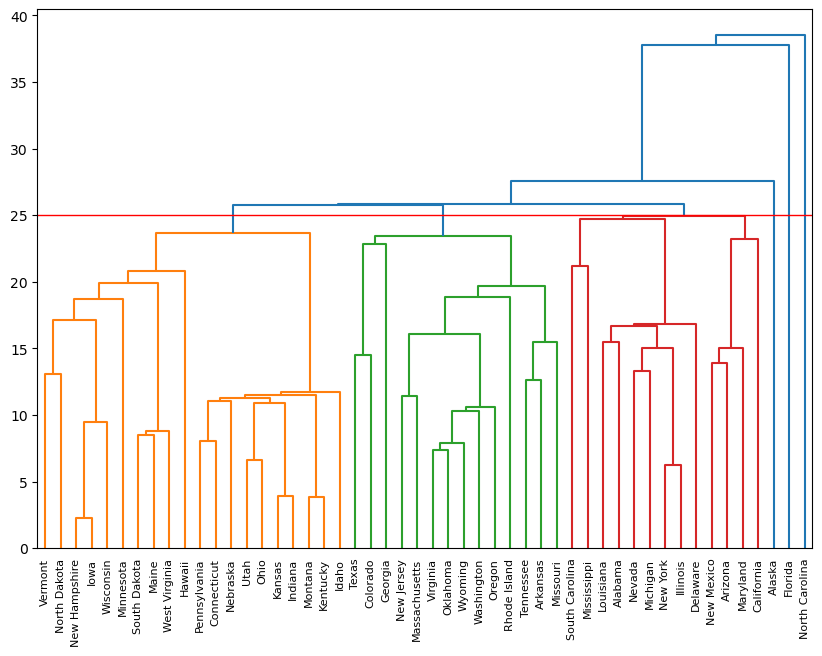

In [2]:
# method 옵션 : 연결법 종류 > single(최단연결법)
# metric 옵션 : 거리 계산 함수 종류 > euclidean ( 유클리디안)
single = linkage(US.iloc[:, 1::], metric ='euclidean', method='single')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(single,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            color_threshold=25,   #군집의 수를 설정하는 Height 값 설정
            show_leaf_counts=True)

plt.axhline(y=25, color='r', linewidth=1)  #Height 값에 따라 선을 그어 적절한 군집 수 설정
plt.show()


#### 와드연결법  예시
- 최단 연결법은 군집 객체의 수가 비슷하지 않아, 군집을 해석하기 어려움
- 이를 보완하기 위해서 와드연결법을 통해서 덴드로그램을 그리면 3개의 군집으로 적절히 나누어지는 것을 확인가능

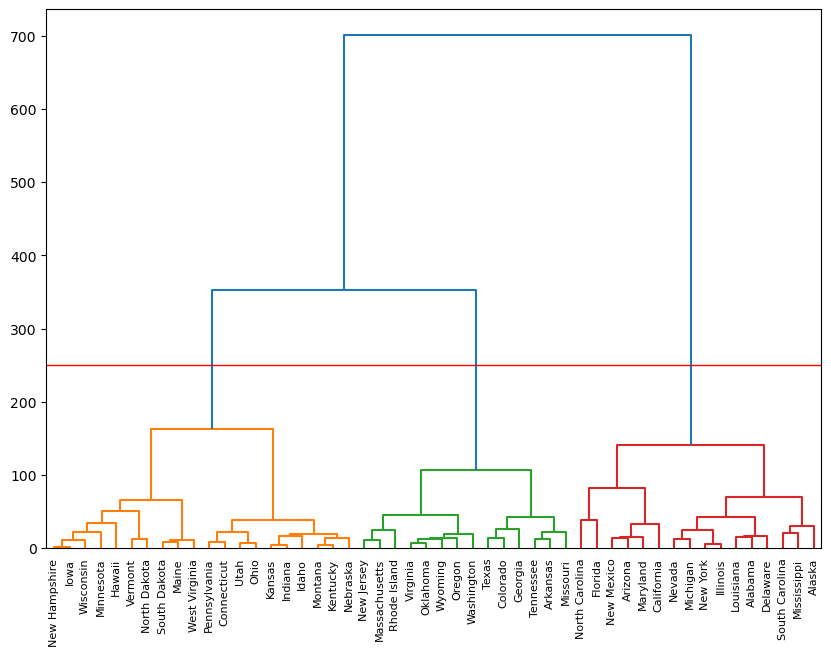

In [3]:
# 와드연결법
ward = linkage(US.iloc[:, 1::], metric ='euclidean', method='ward')
# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(ward,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            color_threshold=250,
            show_leaf_counts=True)
plt.axhline(y=250, color='r', linewidth=1)  #Height 값에 따라 선을 그어 적절한 군집 수 설정
plt.show()


In [4]:
# state마다 어떤 군집에 설정되었는지 확인
assignments = fcluster(ward, 250, 'distance')
assignments


array([1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1,
       3, 1, 2, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1, 3, 2, 2, 3,
       3, 2, 2, 3, 3, 2], dtype=int32)

In [5]:
US['cluster'] = assignments
US.groupby('cluster').mean()


,Murder,Assault,UrbanPop,Rape
cluster,,,,
1,11.812500,272.562500,68.312500,28.375000
2,8.214286,173.285714,70.642857,22.842857
3,4.270000,87.550000,59.750000,14.390000


## 2. 비계층적 군집 분석

### 1) K-means

In [4]:
# 필요한 모듈
import pandas as pd 
from sklearn.cluster import KMeans
# 데이터 로드
iris = pd.read_csv('C:/adp/data/iris.csv')
X = iris.drop('target',axis=1)
X.tail()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### K 값을 정하는 기준
\> 하라바츠 스코어와 엘보우 기법을 활용해서 적절한 K 값을 탑색

#### 하라바츠 스코어

In [7]:
# 클러스터별 콜린스키 하라바츠 결과 비교
from sklearn.metrics import calinski_harabasz_score

for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(X)
    labels = kmeans_model.labels_
    print(calinski_harabasz_score(X, labels))


513.3038433517568
560.3999242466402
529.3982941434156
493.797689822402
474.85419152314864
449.23727032407174
435.6588533945912
403.43595475014206


#### 엘로우 기법

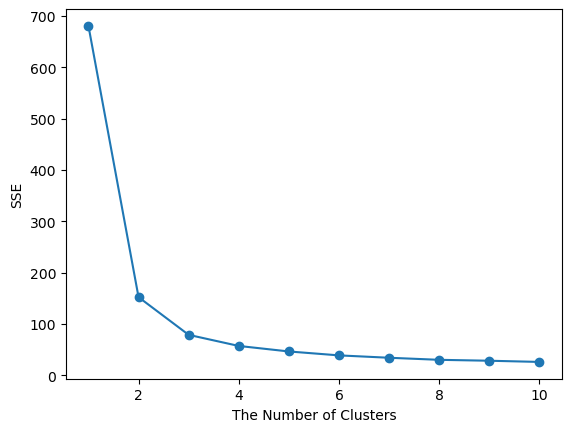

[680.8243999999996, 152.36870647733915, 78.94084142614601, 57.317873214285726, 46.56163015873017, 38.930963049671746, 34.299985543844244, 30.290983238178892, 28.4983205272988, 26.185759370015955]


In [8]:
import matplotlib.pyplot as plt
def elbow(X):
    sse=[]
    for i in range(1, 11):
        km=KMeans(n_clusters=i, random_state=1)
        km.fit(X)
        sse.append(km.inertia_)
    
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('The Number of Clusters')
    plt.ylabel('SSE')
    plt.show()
    print(sse)
elbow(X)

### 실루엣 계수
- 실루엣 계수 지표를 통해서 적절한 클러스터 계수를 구하는 법<br>
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [1]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

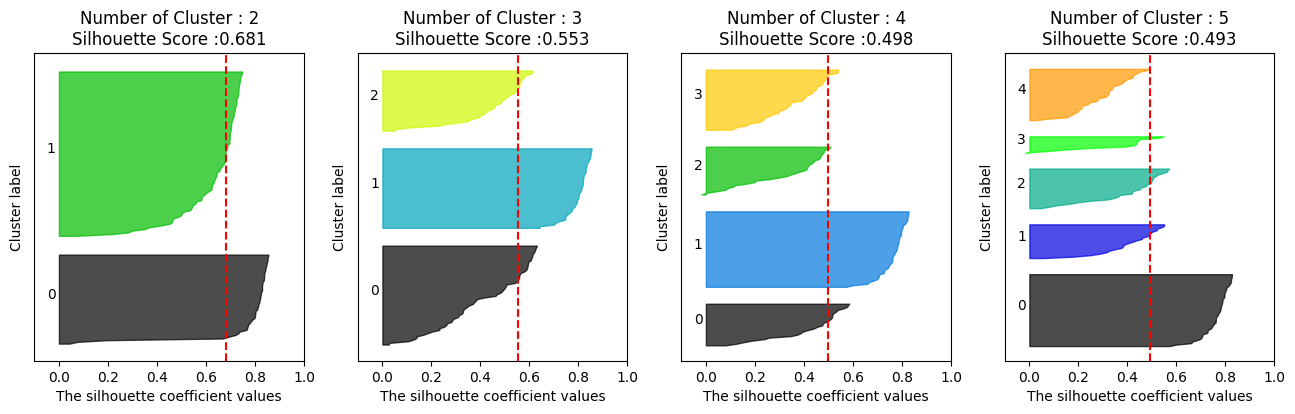

In [5]:
# cluster 개수를 2개, 3개, 4개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4,5], X)

#### 실루엣 분석 결과

\> 개별 군집의 실루엣 분석 계수 평균값의 편차가 크기 않아야함

In [13]:
#최적의 k로  K-Means 군집화 실행
km = KMeans(n_clusters =3, random_state=1)
km.fit(X)
# 할당된 군집을 iris 데이터에 추가
new_labels = km.labels_
iris['cluster'] = new_labels

iris.groupby(['cluster']).mean()


,sepal length,sepal width,petal length,petal width
cluster,,,,
0,5.901613,2.748387,4.393548,1.433871
1,5.006000,3.418000,1.464000,0.244000
2,6.850000,3.073684,5.742105,2.071053


0.12.1


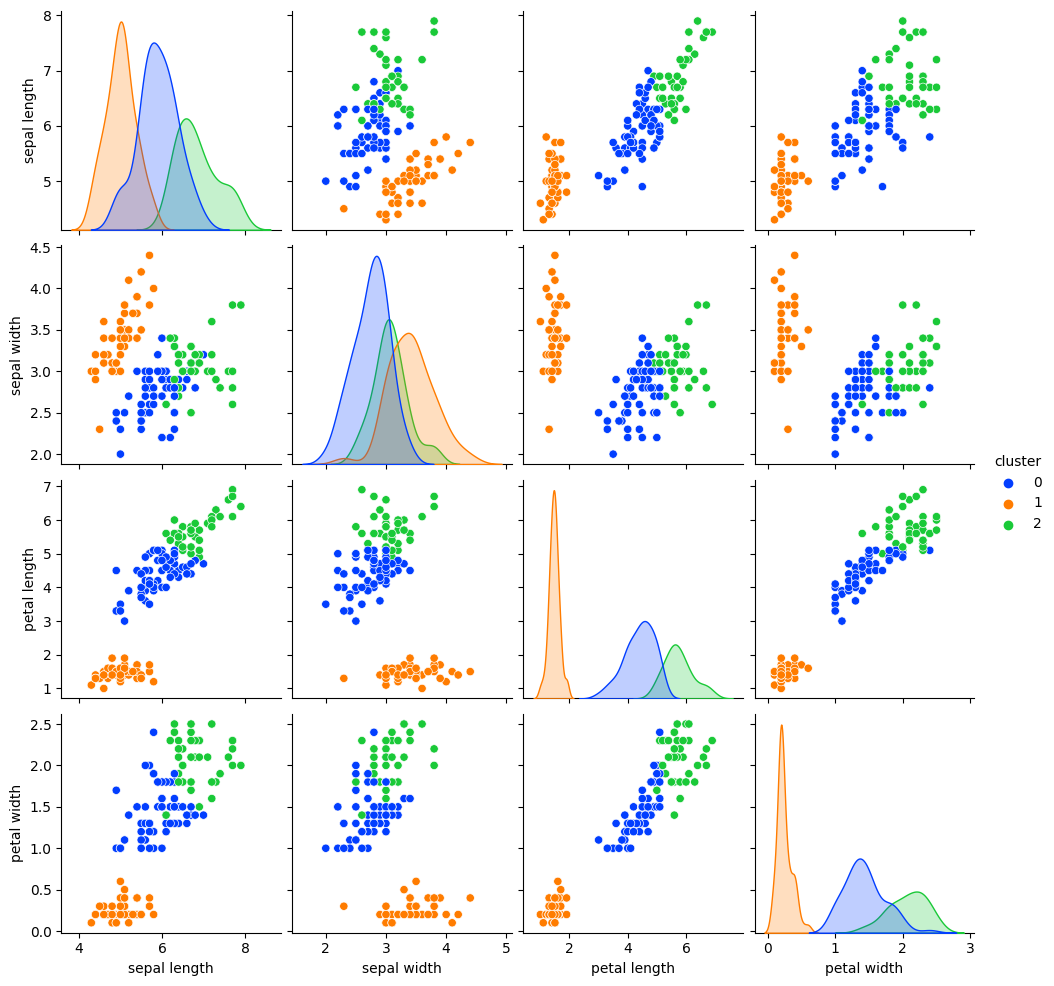

In [14]:
# k-means 시각화 
# 군집결과 시각화

# corner=True. 어찌 됐든 대각선 기준 위, 아래는 결과는 같으니 한쪽만 보려면. corner 옵션에 True
import seaborn as sns
import matplotlib.pyplot as plt

print(sns.__version__)

sns.pairplot(iris,
             vars=['sepal length',	'sepal width',	'petal length',	'petal width'],
             diag_kind='kde',
             hue="cluster", 
#              corner =True,  
             palette='bright')
plt.show()


In [24]:
# 군집분석 후 실루엇 계수 구하기
# 단순 반복으로 구하기
silhouette_score(iris[['sepal length', 'sepal width', 'petal length', 'petal width']], iris['cluster'])

0.5525919445499757

### 2) 혼합분포 군집분석

- 장점: 통계적으로 엄밀한 결과를 얻음
- 단점: 서로 다른 크기나 모양의 군집을 찾을 수 있음
- 사용 알고리즘 : EM

In [30]:
# 필요한 모듈
import pandas as pd 
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# 데이터 로드
iris = pd.read_csv('C:/adp/data/iris.csv')
df = iris.drop('target',axis=1)

#데이터 스케일링
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#가우시안 혼합모델 구축
gmm = GaussianMixture(n_components=3)
gmm.fit(df_scaled)
gmm_labels = gmm.predict(df_scaled)
gmm_labels

array([2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0,
       2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [28]:
#예상 군집을 cluster 변수에 할당
df['gmm_cluster'] = gmm_labels
#군집의 변수별 통계량 확인
clusters = [0,1,2]
df.groupby('gmm_cluster').mean()

,sepal length,sepal width,petal length,petal width
gmm_cluster,,,,
0,5.006000,3.418000,1.464000,0.244000
1,5.904444,2.775556,4.193333,1.293333
2,6.554545,2.950909,5.489091,1.989091


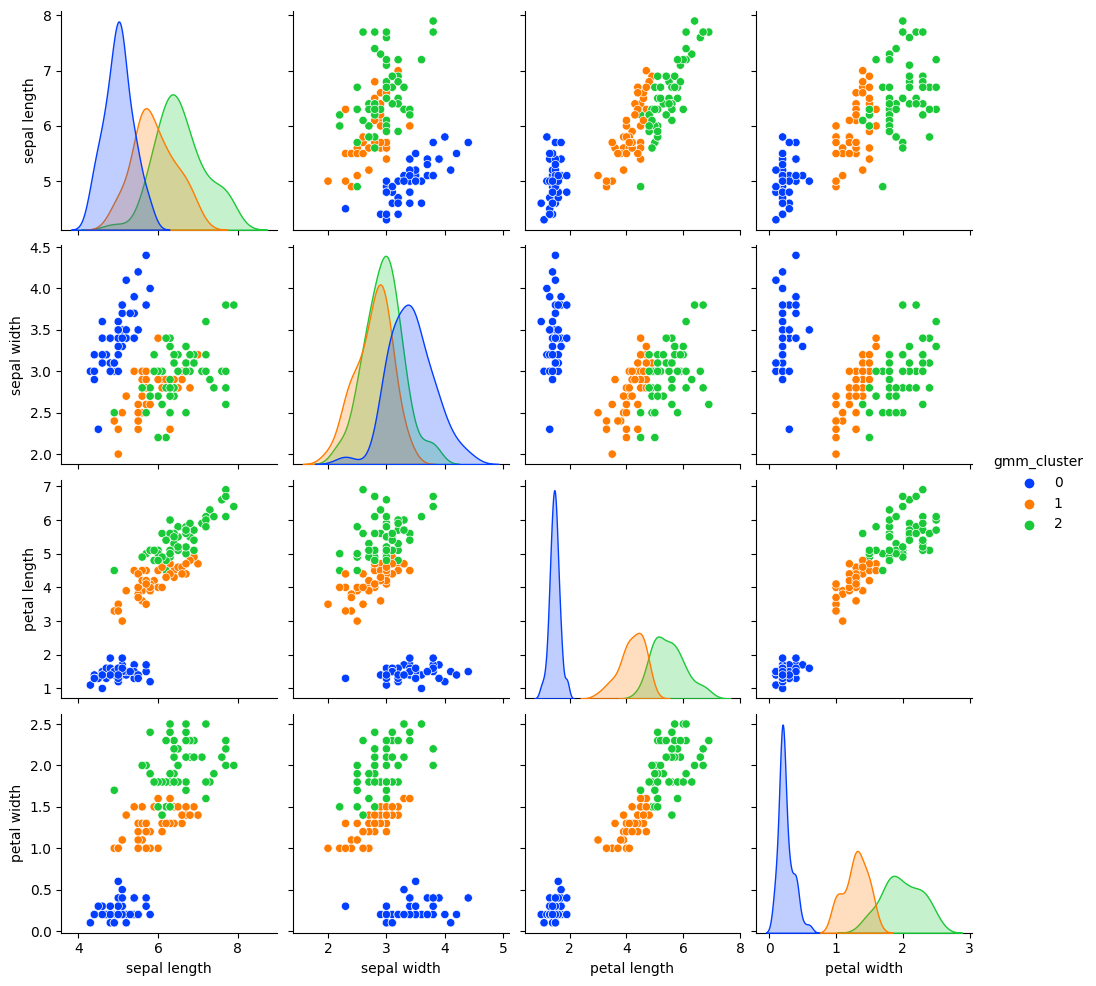

In [29]:
#군집결과 시각화
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df,
            vars=['sepal length',	'sepal width',	'petal length',	'petal width'],
            diag_kind='kde',
            hue = "gmm_cluster",
#             corner = True,
            palette = 'bright')